# Bank clients churn prediction
### Author: Dominik Kurowski
***

### Table of Contents:
#### 0. [Importing libraries and the dataset](#0)
#### 1. [A first glimpse at the data ](#1)
#### 2. [Exploratory Data Analysis (EDA)](#2)
#### 3. [Data cleaning](#3)
#### 4. [Building a classification model (Random Forest)](#4)
#### 5. [Models comparison](#5)
#### 6. [Features importance](#6)
#### 7. [Possible solution to reduce customer attrition](#7)

<br>
A manager at the bank is disturbed with more and more customers leaving their credit card services. They would really appreciate if one could predict for them who is gonna get churned so they can proactively go to the customer to provide them better services and turn customers' decisions in the opposite direction. <br>

**Tasks:**
- Build a classification model predicting churning of customer
- Determine most influential churning factors and use them to suggest possible solutions to reduce customer attrition rate

<br><br>
**Dataset source:** https://www.kaggle.com/sakshigoyal7/credit-card-customers

<a id='0'></a>
# 0. Importing libraries and the dataset
***

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE

%matplotlib inline

In [2]:
data = pd.read_csv("./data/bank_clients.csv")
data.drop(data.columns[[0, -1, -2]], axis=1, inplace=True)

<a id='1'></a>
# 1. A first glimpse at the data 
***

<a id='1.1'></a>
## Fragment of the dataset (first 5 rows)

In [3]:
data.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


<a id='1.2'></a>
## Features description

In [4]:
data.info()
print("\n\nMissing (null) data in dataset:")
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

- **CLIENTNUM** - unique identifier for the customer holding the account <br>
- **Attrition_Flag** - customer activity. *"Existing Customer"* if account is active, *"Attrited Customer"* otherwise <br>
- **Customer_Age** - customer age in years <br>
- **Gender**- "M" = male, "F" = female <br>
- **Dependent_count** - number of dependents <br>
- **Education_Level** - educational qualification of the account holder (example: high school, college graduate, etc.) <br>
- **Marital_Status** - demographic variable (Married, Single, Divorced, Unknown) <br>
- **Income_Category** - annual income category of the account holder (< 40K, 40K - 60K, 60K−80K, 80K−120K, > $120K, Unknown) <br>
- **Card_Category** - type of the card (Blue, Silver, Gold, Platinum) <br>
- **Months_on_book** - period of relationship with bank <br>
- **Total_Relationship_Count** - total no. of products held by the customer <br>
- **Months_Inactive_12_mon** - no. of months inactive in the last 12 months <br>
- **Contacts_Count_12_mon** - no. of contacts in the last 12 months <br>
- **Credit_Limit** - credit Limit on the credit card <br>
- **Total_Revolving_Bal** - total revolving balance on the credit card <br>
- **Avg_Open_To_Buy** - open to buy credit line (average of last 12 months) <br>
- **Total_Amt_Chng_Q4_Q1** - change in transaction amount (Q4 over Q1) <br>
- **Total_Trans_Amt** - total transaction amount (Last 12 months) <br>
- **Total_Trans_Ct** - total transaction count (Last 12 months) <br>
- **Total_Ct_Chng_Q4_Q1** - change in transaction count (Q4 over Q1) <br>
- **Avg_Utilization_Ratio** - average card utilization ratio <br>

<a id='1.3'></a>
## Ratio of the target variable

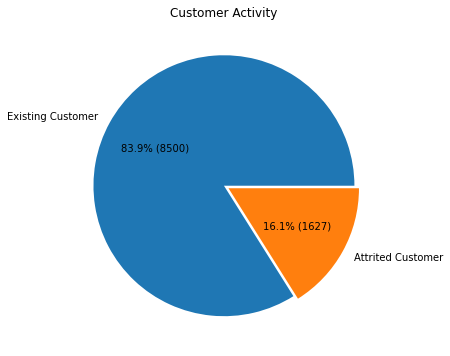

In [5]:
fig, ax = plt.subplots(figsize=(6, 6))
values = data["Attrition_Flag"].value_counts()
labels = data["Attrition_Flag"].unique()

ax.pie(values, explode=(0.0, 0.04), labels=labels, autopct=lambda x:f'{x:.1f}% ({x*values.sum()/100 :.0f})')
ax.set_title("Customer Activity")
plt.show()

### Observations:
- Our data is quite imbalance. There are 8500 cases of active customers and 1627 of inactive ones. This type of split may negatively affect our model's predictions. We will try to fix it by using one of the oversampling technique - SMOTE.


<a id='1.4'></a>
## Summary
- Our dataset consists of both numerical (int, float) and object (string) type features
- To ensure that our model is trained correctly, we need to convert all **'object'** (string) type features to **'category'**
- There are no null values in our dataset
- We work on an imbalanced data. We will try to fix it by using one of the balancing technique - **SMOTE**

# 2. Exploratory Data Analysis (EDA)
***

## Breakdown of categorical features

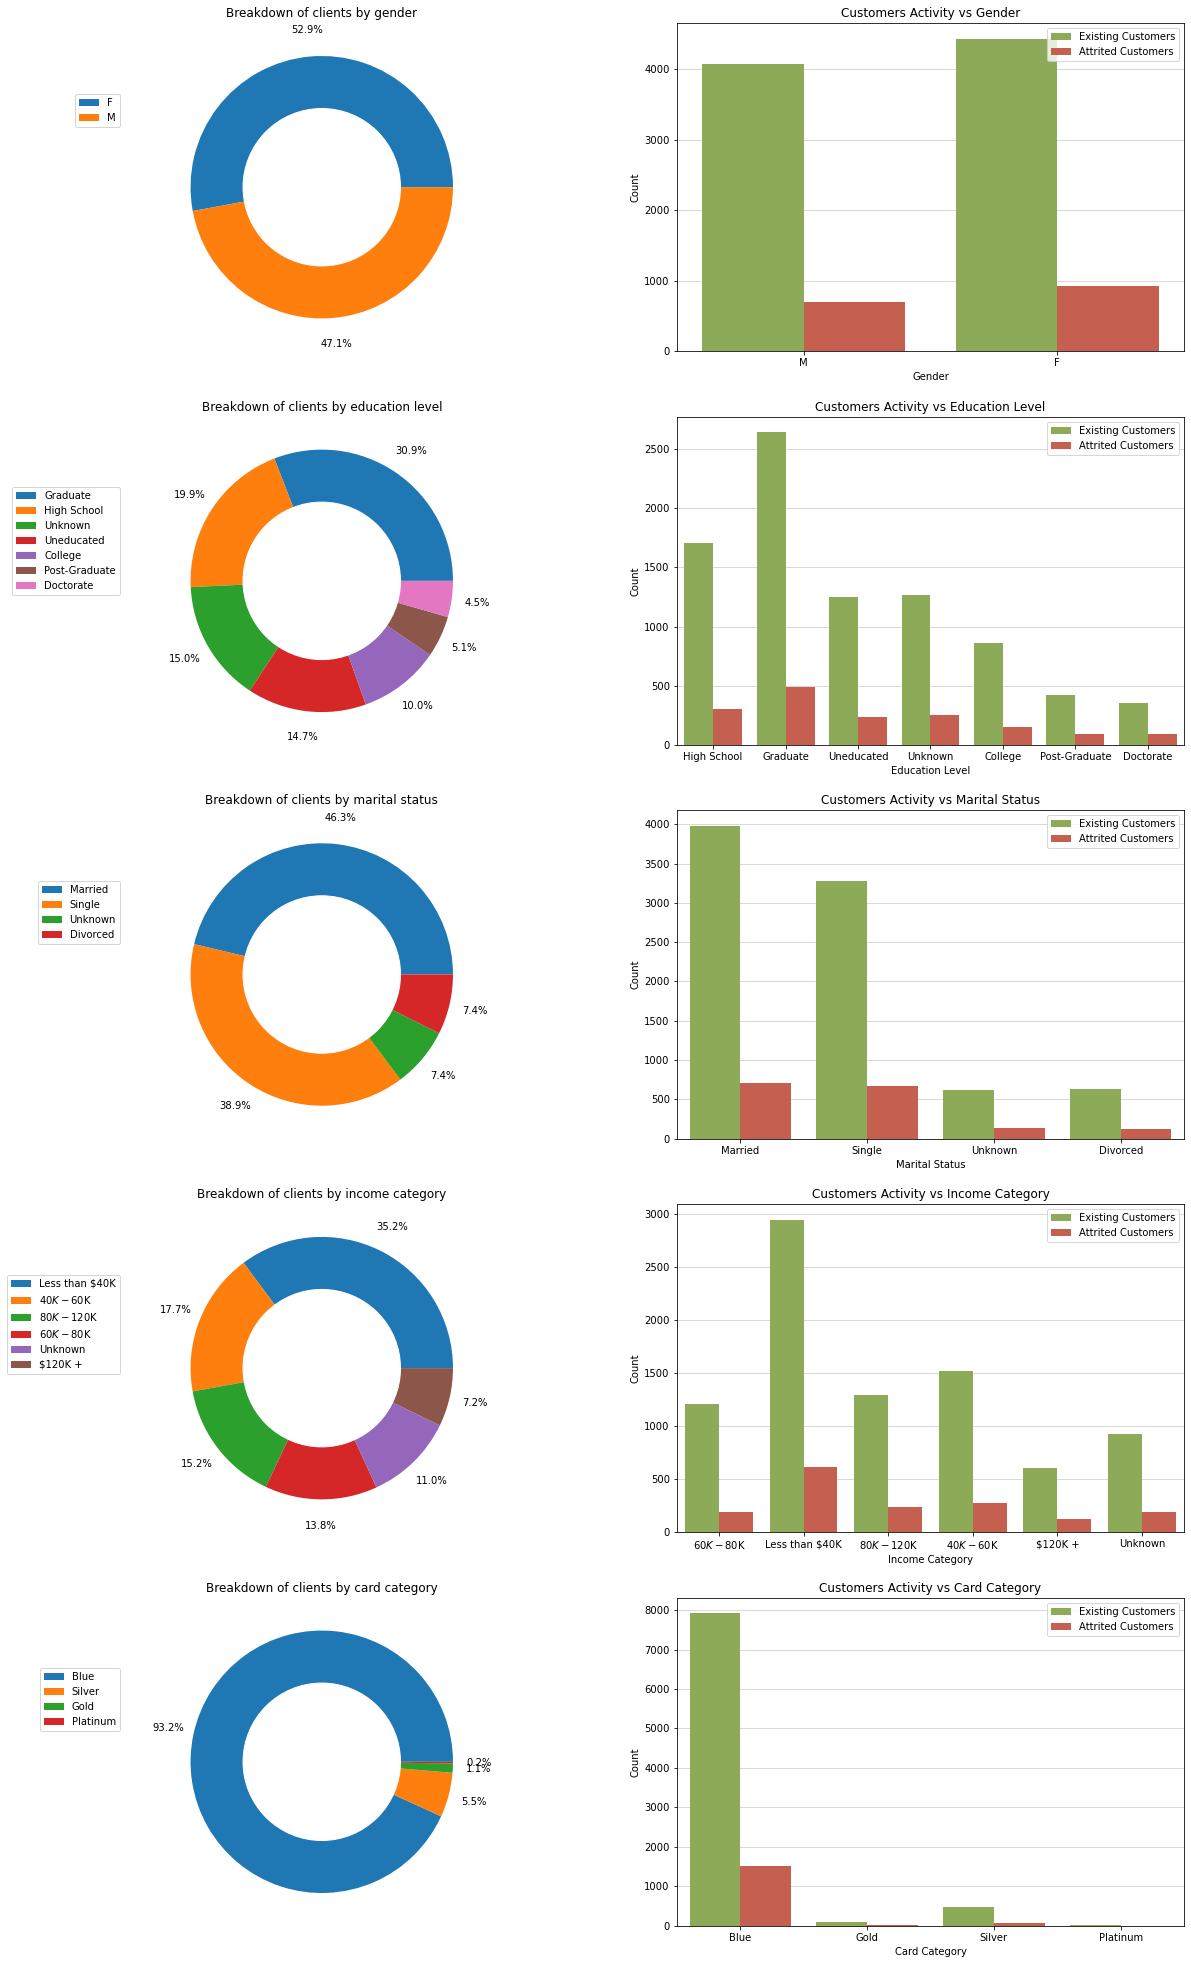

In [6]:
fig, ax = plt.subplots(5, 2, figsize=(20, 35))
keys_to_plot = ["Gender", "Education_Level", "Marital_Status", "Income_Category", "Card_Category"]
for key, i in zip(keys_to_plot, range(len(keys_to_plot))):
    values = data[key].value_counts()
    labels = values.index
    name = key.replace("_", " ")

    circle = plt.Circle((0,0), 0.6, color='white')
    patches, _, _ = ax[i, 0].pie(values, autopct="%1.1f%%", pctdistance=1.2)
    ax[i, 0].legend(patches, labels, bbox_to_anchor=(-0.1, 0.8))
    ax[i, 0].add_patch(circle)
    ax[i, 0].set_title(f'Breakdown of clients by {name.lower()}')

    sns.countplot(data=data, x=key, hue='Attrition_Flag', palette=["#91B84A", "#D9513B"], ax=ax[i, 1])
    ax[i, 1].grid(axis='y', alpha=0.6)
    ax[i, 1].set_axisbelow(True)
    ax[i, 1].set(title=f'Customers Activity vs {name}', xlabel=name, ylabel = 'Count')
    ax[i, 1].legend(["Existing Customers", "Attrited Customers"], loc="upper right")

plt.show()

### Observations:
- The clients of this bank are evenly distributed by gender
- The most numerous group in terms of annual income are people earning less than $40k
- Only 6.8% of customers own a card other than the blue one

## Breakdown of numerical features

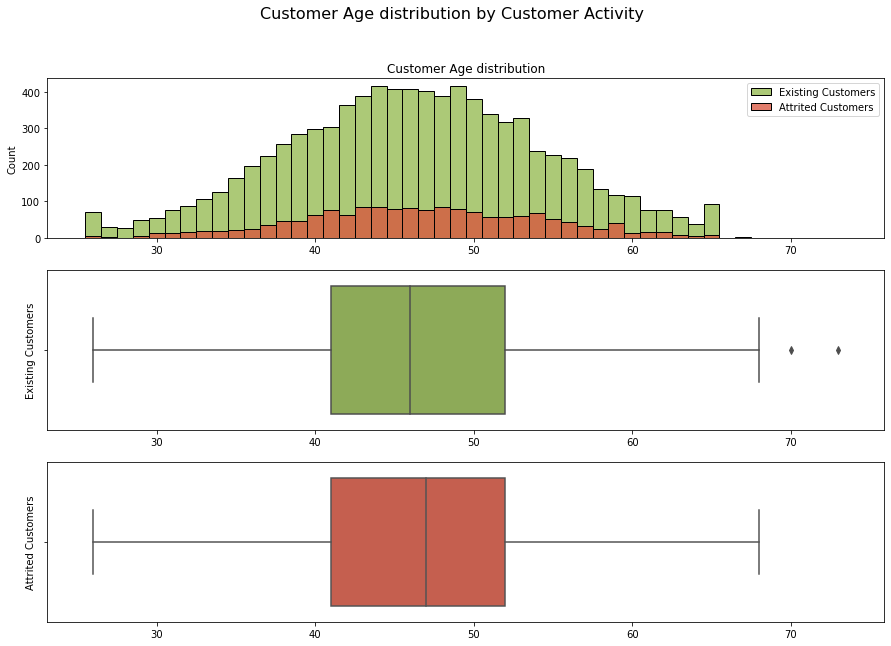

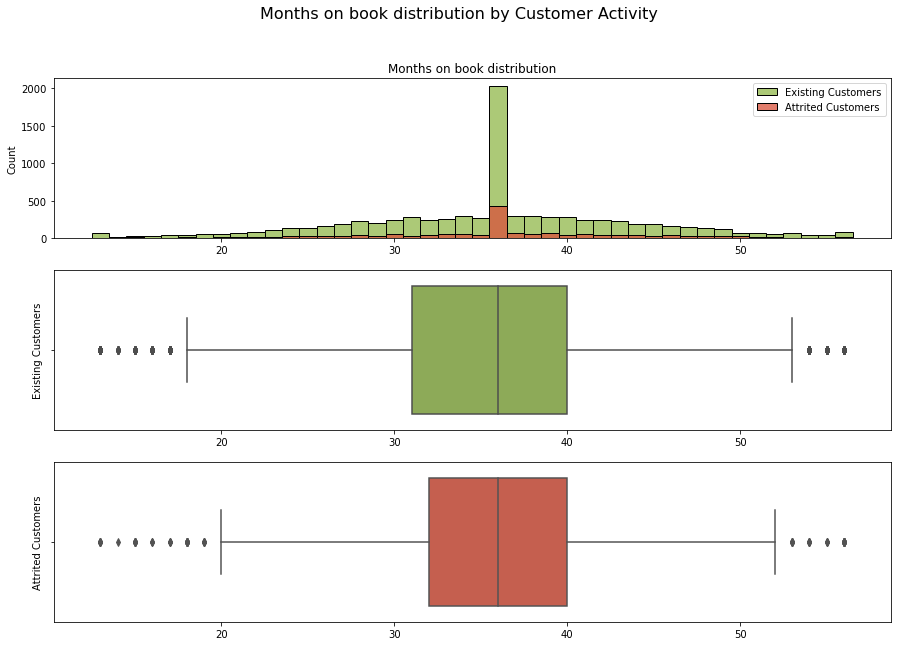

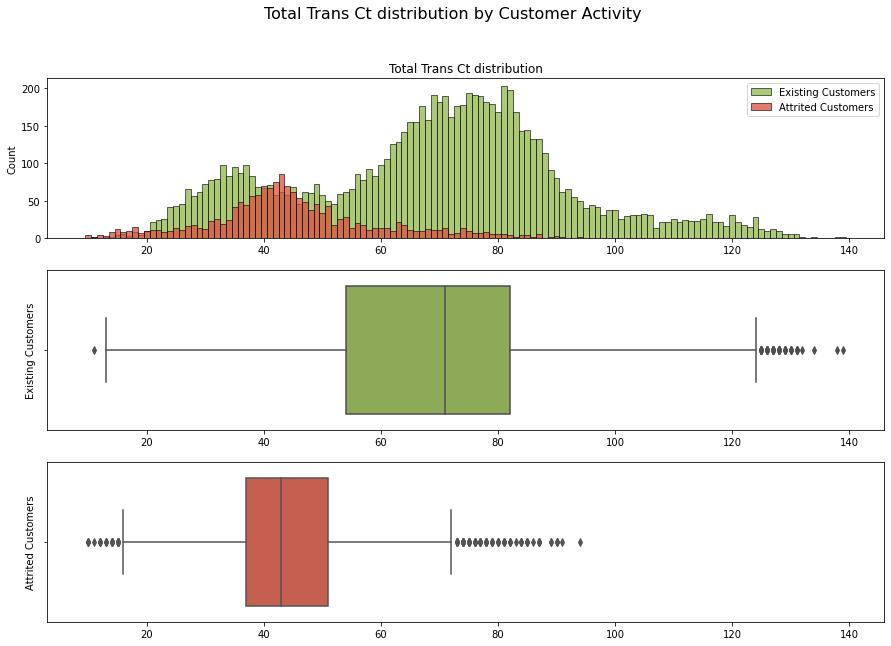

In [7]:
keys_to_plot = ["Customer_Age", "Months_on_book", "Total_Trans_Ct"]

for key in keys_to_plot:
    name = key.replace("_", " ")

    fig, ax = plt.subplots(3, 1, figsize=(15, 10), sharex='col')

    existing = data[data["Attrition_Flag"]=="Existing Customer"]
    attrited = data[data["Attrition_Flag"]=="Attrited Customer"]

    sns.histplot(data=existing, x=key, color="#91B84A", ax=ax[0], discrete=True)
    sns.histplot(data=attrited, x=key, color="#D9513B", ax=ax[0], discrete=True)
    ax[0].set(title=f"{name} distribution", xlabel=name)
    ax[0].legend(labels=["Existing Customers", "Attrited Customers"], loc="upper right")
    ax[0].xaxis.set_tick_params(labelbottom=True)

    sns.boxplot(data=existing, x=key, color="#91B84A", ax=ax[1])
    ax[1].set(ylabel="Existing Customers", xlabel="")
    ax[1].xaxis.set_tick_params(labelbottom=True)

    sns.boxplot(data=attrited, x=key, color="#D9513B", ax=ax[2])
    ax[2].set(ylabel="Attrited Customers", xlabel="")
    ax[2].xaxis.set_tick_params(labelbottom=True)

    fig.suptitle(f"{name} distribution by Customer Activity", fontsize=16)

    plt.show()

### Observations:
- Customers age variable follow the normal distribution
- Customers with Total Transaction Count below 50 (within 12 months) are more likely to resign from their bank's services

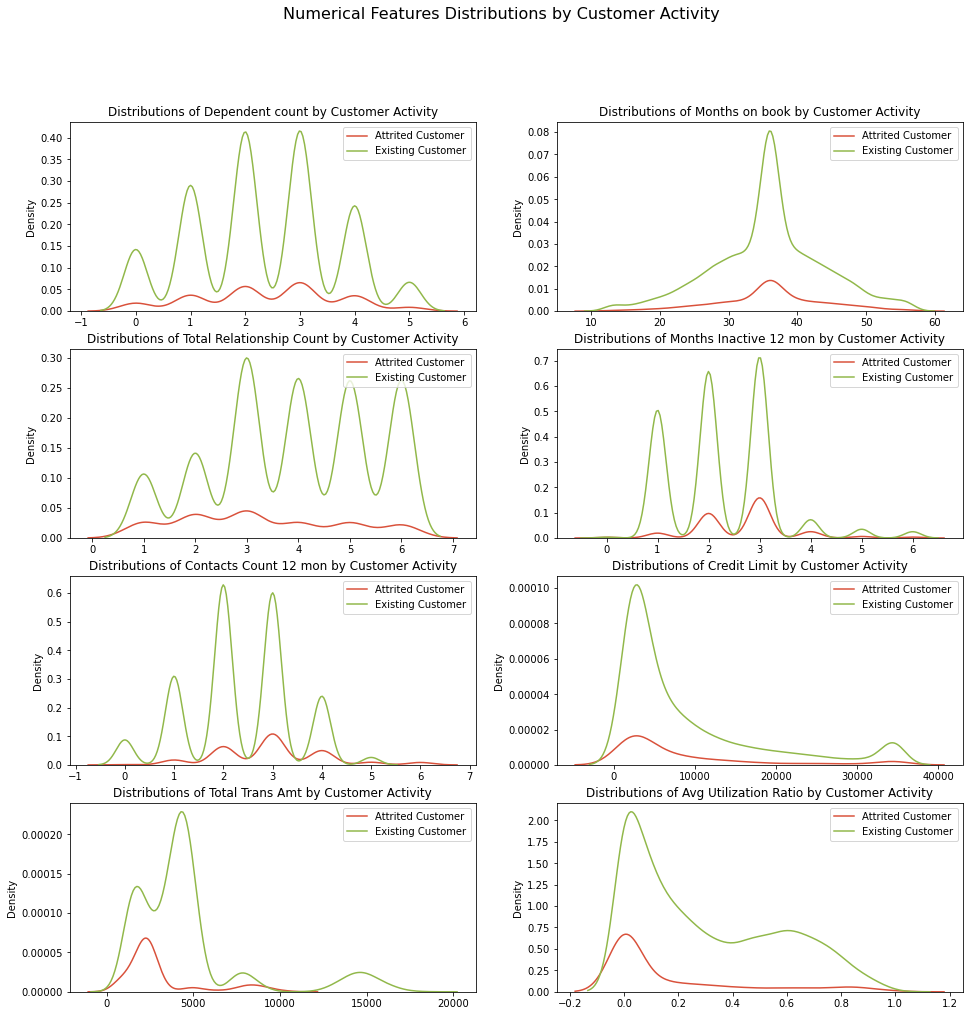

In [8]:
keys_to_plot = ["Dependent_count", "Months_on_book", "Total_Relationship_Count", "Months_Inactive_12_mon",
                "Contacts_Count_12_mon", "Credit_Limit", "Total_Trans_Amt", "Avg_Utilization_Ratio"]

fig, axs = plt.subplots(4, 2, figsize=(16, 16))
axs = axs.flatten()

for ax, key in zip(axs, keys_to_plot):
    name = key.replace("_", " ")

    sns.kdeplot(data=data, x=key, hue="Attrition_Flag", palette=["#91B84A", "#D9513B"], ax=ax)
    ax.legend(loc="upper right", labels=["Attrited Customer", "Existing Customer"])
    ax.set_title(f"Distributions of {name} by Customer Activity")
    ax.set(xlabel="")

fig.suptitle('Numerical Features Distributions by Customer Activity',fontsize=16)
plt.show()

<a id='3'></a>
# 3. Data cleaning
***

## Conversion from 'object' dtype to 'category'

This operation allows us to assign numerical values ​​to string type labels in the later part of this notebook.

In [9]:
columns_with_object_type = data.columns[data.dtypes == 'object']
for column in columns_with_object_type:
    data[column] = data[column].astype('category')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Attrition_Flag            10127 non-null  category
 1   Customer_Age              10127 non-null  int64   
 2   Gender                    10127 non-null  category
 3   Dependent_count           10127 non-null  int64   
 4   Education_Level           10127 non-null  category
 5   Marital_Status            10127 non-null  category
 6   Income_Category           10127 non-null  category
 7   Card_Category             10127 non-null  category
 8   Months_on_book            10127 non-null  int64   
 9   Total_Relationship_Count  10127 non-null  int64   
 10  Months_Inactive_12_mon    10127 non-null  int64   
 11  Contacts_Count_12_mon     10127 non-null  int64   
 12  Credit_Limit              10127 non-null  float64 
 13  Total_Revolving_Bal       10127 non-null  int6

## List of categorical data unique values

In [10]:
columns_with_object_type = data.columns[data.dtypes == 'category']
for column in columns_with_object_type:
    print(column, ":", data[column].unique(), "\n")

Attrition_Flag : ['Existing Customer', 'Attrited Customer']
Categories (2, object): ['Existing Customer', 'Attrited Customer'] 

Gender : ['M', 'F']
Categories (2, object): ['M', 'F'] 

Education_Level : ['High School', 'Graduate', 'Uneducated', 'Unknown', 'College', 'Post-Graduate', 'Doctorate']
Categories (7, object): ['High School', 'Graduate', 'Uneducated', 'Unknown', 'College', 'Post-Graduate', 'Doctorate'] 

Marital_Status : ['Married', 'Single', 'Unknown', 'Divorced']
Categories (4, object): ['Married', 'Single', 'Unknown', 'Divorced'] 

Income_Category : ['$60K - $80K', 'Less than $40K', '$80K - $120K', '$40K - $60K', '$120K +', 'Unknown']
Categories (6, object): ['$60K - $80K', 'Less than $40K', '$80K - $120K', '$40K - $60K', '$120K +', 'Unknown'] 

Card_Category : ['Blue', 'Gold', 'Silver', 'Platinum']
Categories (4, object): ['Blue', 'Gold', 'Silver', 'Platinum'] 



## Integer encoding of categorical data with hierarchical structure


Integer encoding can be applied when given variables are hierarchical in nature (you can arrange them from the highest value to the lowest). Features from our dataset that display this property are:
 - Education level (ranked from uneducated to doctorate)
 - Income category (from less than \$40K to more than \$120K)
 - Card category (blue card is the worst one, the silver, gold and platinum)

In [11]:
data["Education_Level"].cat.reorder_categories(["Unknown", "Uneducated", "High School", "College", "Graduate", "Post-Graduate", "Doctorate"], inplace=True)
data["Education_Level"] = data["Education_Level"].cat.codes

data["Income_Category"].cat.reorder_categories(["Unknown", "Less than $40K", "$40K - $60K", "$60K - $80K", "$80K - $120K", "$120K +"], inplace=True)
data["Income_Category"] = data["Income_Category"].cat.codes

data["Card_Category"].cat.reorder_categories(["Blue", "Silver", "Gold", "Platinum"], inplace=True)
data["Card_Category"] = data["Card_Category"].cat.codes

data["Attrition_Flag"].cat.reorder_categories(["Existing Customer", "Attrited Customer"], inplace=True)
data["Attrition_Flag"] = data["Attrition_Flag"].cat.codes

## One hot encoding of categorical data with non-hierarchical structure

When there is no rule to rank the values from lowest to highest, we can use one hot encoding. It removes given categorical variable and adds a new binary variable for each unique category label.

In [12]:
columns_with_category_type = data.columns[data.dtypes == 'category']
data = pd.get_dummies(data, columns=columns_with_category_type)

<a id='4'></a>
# 4. Building a classification model (Random Forest)
***

## Splitting the data between training and test sets

In [13]:
x = data.drop("Attrition_Flag", axis=1)
y = data["Attrition_Flag"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle= True, stratify = y)

## Building a base model

In [14]:
accuracies = []
recalls = []
confusion_matrices = []

rfc_1 = RandomForestClassifier()
rfc_1.fit(x_train, y_train)
y_pred = rfc_1.predict(x_test)

accuracy = []
for _ in range(10):
    rfc_1 = RandomForestClassifier()
    rfc_1.fit(x_train, y_train)
    y_pred = rfc_1.predict(x_test)
    accuracy.append(accuracy_score(y_test, y_pred))
accuracies.append(accuracy)

recall = []
for _ in range(10):
    rfc_1 = RandomForestClassifier()
    rfc_1.fit(x_train, y_train)
    y_pred = rfc_1.predict(x_test)
    recall.append(recall_score(y_test, y_pred))
recalls.append(recall)

confusion_matrices.append(confusion_matrix(y_test, y_pred, normalize="all"))

print("Base model:")
print("----------------------------------------------------")
print(classification_report(y_test, y_pred))
print('Accuracy_Score: %0.3f' % accuracy_score(y_test, y_pred))
print('Recall: %0.3f' % recall_score(y_test, y_pred))

Base model:
----------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1701
           1       0.95      0.78      0.86       325

    accuracy                           0.96      2026
   macro avg       0.95      0.89      0.92      2026
weighted avg       0.96      0.96      0.96      2026

Accuracy_Score: 0.959
Recall: 0.785


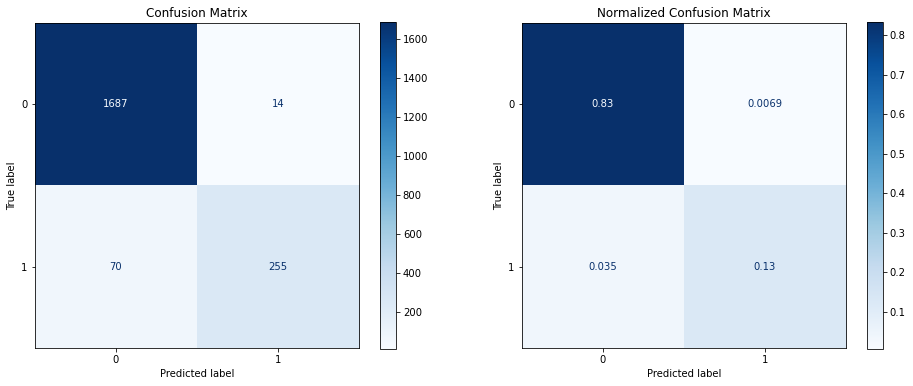

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

plot_confusion_matrix(rfc_1, x_test, y_test, cmap='Blues', ax=ax[0])  
ax[0].set_title("Confusion Matrix")

plot_confusion_matrix(rfc_1, x_test, y_test, normalize="all", cmap='Blues', ax=ax[1])  
ax[1].set_title("Normalized Confusion Matrix")

plt.show()

## Removing the uncorrelated data

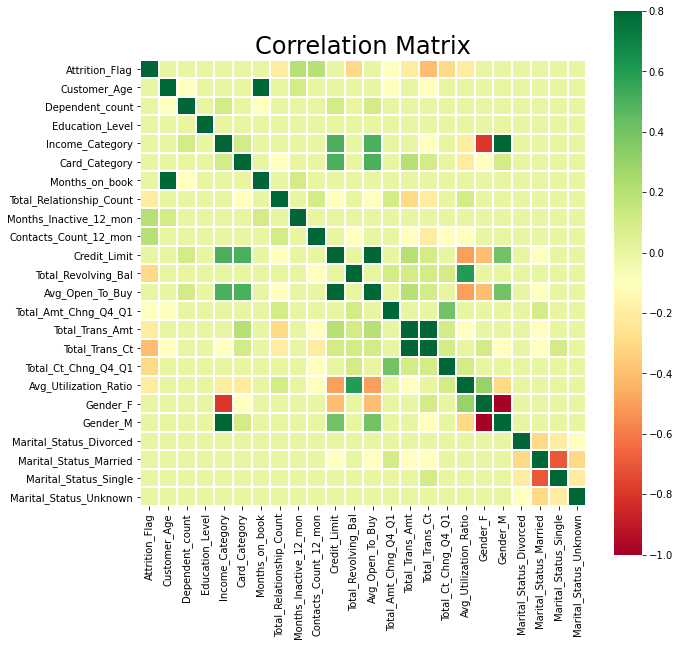

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(data.corr().round(1), linewidths=0.1, vmax=0.8, square=True, cmap="RdYlGn", linecolor="w", ax=ax)
ax.set_title("Correlation Matrix", fontsize=24)
plt.show()

In [17]:
THRESHOLD = 0.01

price_corr = data.corr()["Attrition_Flag"]
not_correlated_keys = price_corr[price_corr.abs() < THRESHOLD].keys()

x_train = x_train.drop(not_correlated_keys, axis=1)
x_test = x_test.drop(not_correlated_keys, axis=1)

In [18]:
rfc_2 = RandomForestClassifier()
rfc_2.fit(x_train, y_train)
y_pred = rfc_2.predict(x_test)

accuracy = []
for _ in range(10):
    rfc_2 = RandomForestClassifier()
    rfc_2.fit(x_train, y_train)
    y_pred = rfc_2.predict(x_test)
    accuracy.append(accuracy_score(y_test, y_pred))
accuracies.append(accuracy)

recall = []
for _ in range(10):
    rfc_2 = RandomForestClassifier()
    rfc_2.fit(x_train, y_train)
    y_pred = rfc_2.predict(x_test)
    recall.append(recall_score(y_test, y_pred))
recalls.append(recall)

confusion_matrices.append(confusion_matrix(y_test, y_pred, normalize="all"))

print("Model after removing uncorrelated features:")
print("----------------------------------------------------")
print(classification_report(y_test, y_pred))
print('Accuracy_Score: %0.3f' % accuracy_score(y_test, y_pred))
print('Recall: %0.3f' % recall_score(y_test, y_pred))

Model after removing uncorrelated features:
----------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1701
           1       0.94      0.80      0.87       325

    accuracy                           0.96      2026
   macro avg       0.95      0.90      0.92      2026
weighted avg       0.96      0.96      0.96      2026

Accuracy_Score: 0.960
Recall: 0.803


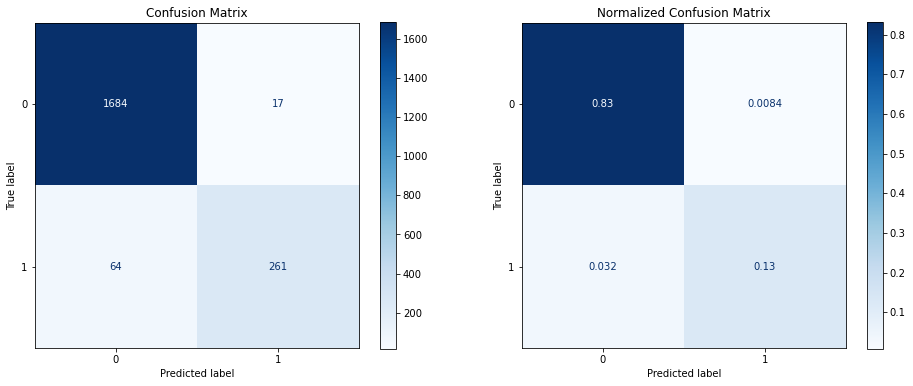

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

plot_confusion_matrix(rfc_2, x_test, y_test, cmap='Blues', ax=ax[0])  
ax[0].set_title("Confusion Matrix")

plot_confusion_matrix(rfc_2, x_test, y_test, normalize="all", cmap='Blues', ax=ax[1])  
ax[1].set_title("Normalized Confusion Matrix")

plt.show()

## Balancing the training data using SMOTE

In [20]:
sm = SMOTE(sampling_strategy='auto', k_neighbors=8, random_state=101)
x_res, y_res = sm.fit_resample(x_train, y_train)

In [21]:
rfc_3 = RandomForestClassifier()
rfc_3.fit(x_res, y_res)
y_pred = rfc_3.predict(x_test)

accuracy = []
for _ in range(10):
    rfc_3 = RandomForestClassifier()
    rfc_3.fit(x_res, y_res)
    y_pred = rfc_3.predict(x_test)
    accuracy.append(accuracy_score(y_test, y_pred))
accuracies.append(accuracy)

recall = []
for _ in range(10):
    rfc_3 = RandomForestClassifier()
    rfc_3.fit(x_res, y_res)
    y_pred = rfc_3.predict(x_test)
    recall.append(recall_score(y_test, y_pred))
recalls.append(recall)

confusion_matrices.append(confusion_matrix(y_test, y_pred, normalize="all"))

print("Model after data balancing (SMOTE):")
print("----------------------------------------------------")
print(classification_report(y_test, y_pred))
print('Accuracy_Score: %0.3f' % accuracy_score(y_test, y_pred))
print('Recall: %0.3f' % recall_score(y_test, y_pred))

Model after data balancing (SMOTE):
----------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1701
           1       0.89      0.88      0.89       325

    accuracy                           0.96      2026
   macro avg       0.93      0.93      0.93      2026
weighted avg       0.96      0.96      0.96      2026

Accuracy_Score: 0.963
Recall: 0.883


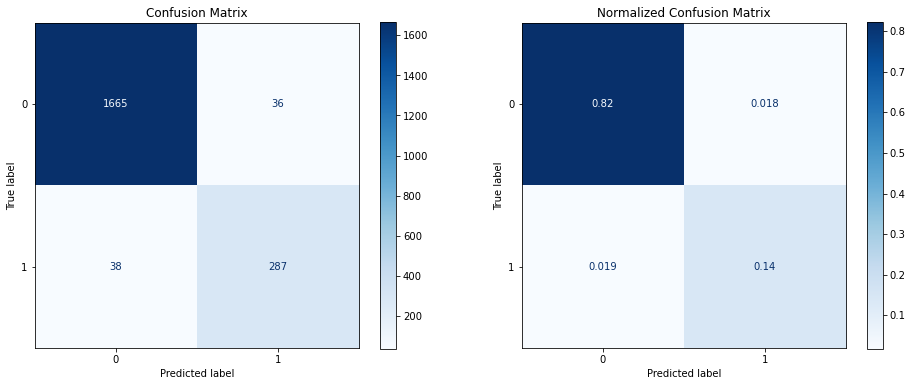

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

plot_confusion_matrix(rfc_3, x_test, y_test, cmap='Blues', ax=ax[0])  
ax[0].set_title("Confusion Matrix")

plot_confusion_matrix(rfc_3, x_test, y_test, normalize="all", cmap='Blues', ax=ax[1])  
ax[1].set_title("Normalized Confusion Matrix")

plt.show()

<a id='5'></a>
# 5. Models comparison
***

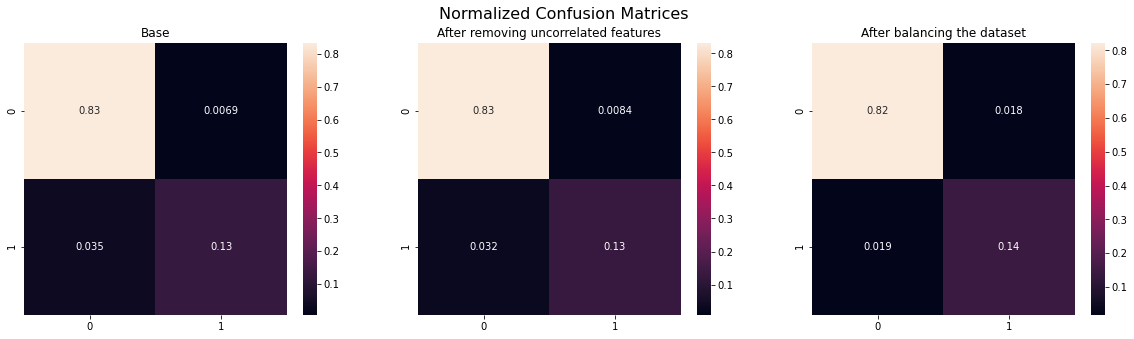

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

fig.suptitle("Normalized Confusion Matrices", fontsize=16)

sns.heatmap(confusion_matrices[0], ax=ax[0], annot=True)
ax[0].set_title("Base")

sns.heatmap(confusion_matrices[1], ax=ax[1], annot=True)
ax[1].set_title("After removing uncorrelated features")

sns.heatmap(confusion_matrices[2], ax=ax[2], annot=True)  
ax[2].set_title("After balancing the dataset")

plt.show()

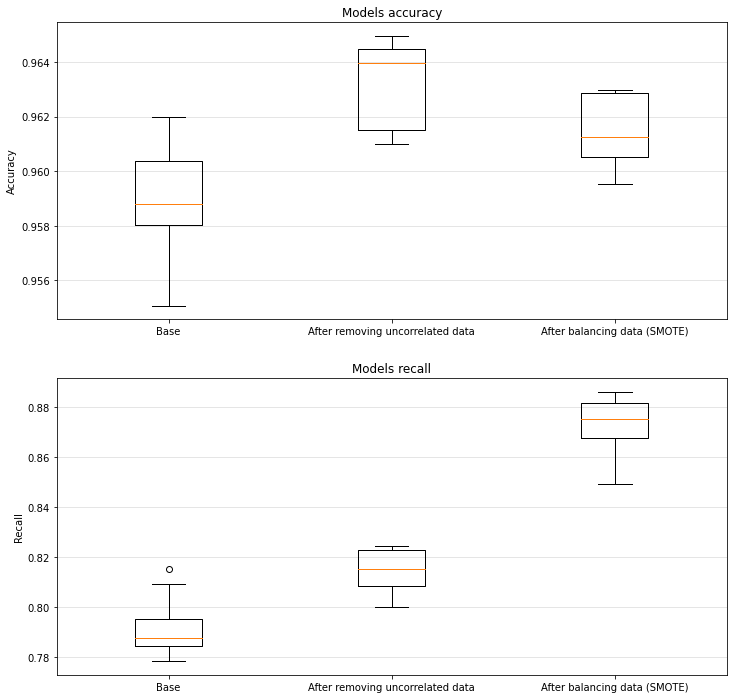

In [24]:
models_names = ["Base", "After removing uncorrelated data", "After balancing data (SMOTE)"]

accuracy_df = pd.DataFrame(accuracies, index=models_names).T
recall_df = pd.DataFrame(recalls, index=models_names).T

fig, ax = plt.subplots(2, 1, figsize=(12,12))

ax[0].boxplot(accuracy_df)
ax[0].set(title='Models accuracy', xlabel='', ylabel='Accuracy')
ax[0].set(xticklabels=models_names)
ax[0].grid(axis='y', alpha=0.4)

ax[1].boxplot(recall_df)
ax[1].set(title='Models recall', xlabel='', ylabel='Recall')
ax[1].set(xticklabels=models_names)
ax[1].grid(axis='y', alpha=0.4)

plt.show()

<a id='6'></a>
# 6. Features importance
***

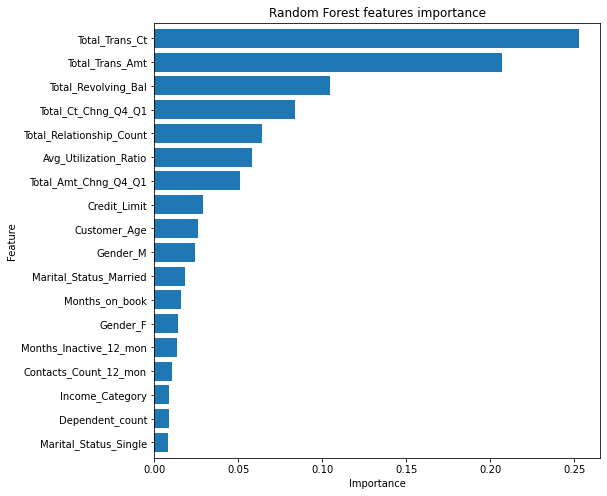

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))

pd.Series(rfc_3.feature_importances_, x_res.columns).sort_values(ascending=True).plot.barh(width=0.8, ax=ax)
ax.set(title="Random Forest features importance", xlabel="Importance", ylabel="Feature")

plt.show()

### Observations:
- The top 4 most influential factors in predicting customer churn are: <br>
    1. Total Transation Count (in last 12 months) <br>
    2. Total Transation Amount (in last 12 months) <br>
    3. Total Revolving Balance on the Credit Card <br>
    4. Change in Transaction Amount (Q4 over Q1) <br>


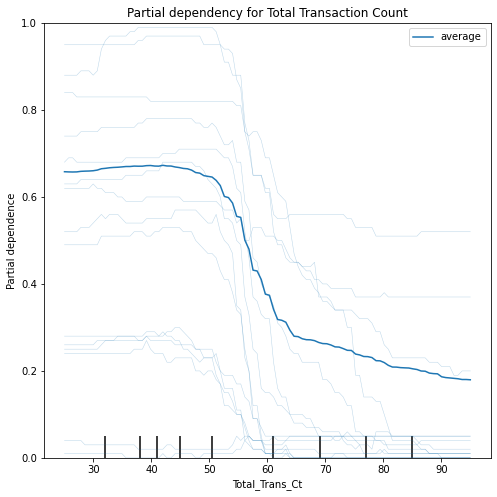

In [26]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.set(title="Partial dependency for Total Transaction Count")
plot_partial_dependence(rfc_3, x_res, features=["Total_Trans_Ct"], kind="both", subsample=15, ax=ax)

plt.show()

### Observations:
- When the total amount of transactions gets lower than 50 (within 12 months) it is most likely that the customer will leave the bank. 


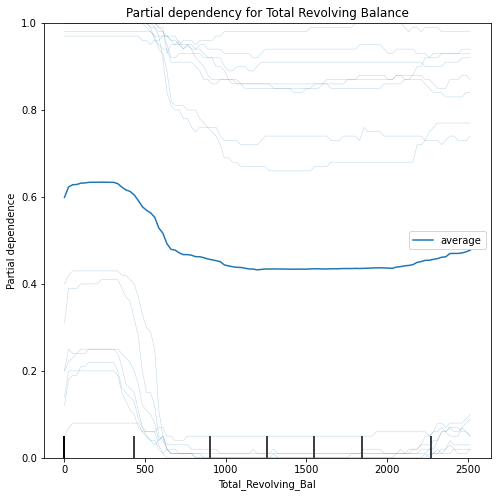

In [28]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.set(title="Partial dependency for Total Revolving Balance")
plot_partial_dependence(rfc_3, x_res, features=["Total_Revolving_Bal"], kind="both", subsample=15, ax=ax)

plt.show()

### Observations:
- It is most likely that the customer will leave the bank if his total revolving balance is lower than 500$.


<a id='7'></a>
# 7. Possible solution to reduce customer attrition

 - **Reach clients when his total transactions count/amount is low** - the greatest probability of the customer leaving the bank occurs when his total transactions count is lower than 50 (within 12 months). The best way to prevent it would be to try to contact such a client and offer him a new or better service/contract. This would increase the customer satisfaction and possibly discard his decision to leave the bank.
- **Prioritize customers with low total revolving balance** - the analysis shows a relationship between low total revolving balance and the likelihood of leaving the bank. That's why, when searching clients with lowest total transactions count, it would be wise to use total revolving balance as the second criterion. This way we will reach people with highest possible chance of churning first, resulting in even lower attrition rate.